In [1]:
import os
from itertools import groupby
import numpy as np
from nltk.stem import PorterStemmer
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

plt.style.use('ggplot')

## Visualize TF-IDF

In [ ]:
total_compo = 5

for j in range(total_compo):
    
    # every batch is considered as one document
    result = [x.strip() for x in open('./output/DialogWAE_GMP_k5_DailyDial_Com{}_valid_results.txt'.format(str(j))).readlines()]
    batches = [list(g) for k,g in groupby(result,lambda x:'Batch' in x) if not k] # split into batches

    # concatenate all response together 
    responses = []
    for line in batches:
        this_batch = []
        # skip no context cases
        context_ct = (' ').join(line).count('Context')
        if context_ct <= 1:
            continue

        for sent in line:
            if 'Sample' in sent:
                this_batch.append(sent.split('>> ')[1].split(' </s>')[0])
        
        responses.append(' '.join([x.lower() for x in this_batch]))
    
    # strip symbols
    symbols = "!#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
    response_f = []
    for r in responses:
        for i in symbols:
            r = r.replace(i, ' ') 
        response_f.append(r)
        
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(response_f)
    print('Vocab size', len(vectorizer.get_feature_names()))
    print('# Documents', len(X.toarray()))
    
    
    # construct a dataframe
    transformed_documents_as_array = X.toarray()
    for k in range(len(transformed_documents_as_array)):
        # construct a dataframe -- pick 1 example 
        tf_idf_tuples = list(zip(vectorizer.get_feature_names(), transformed_documents_as_array[k]))
        one_doc_as_df = pd.DataFrame.from_records(tf_idf_tuples, columns=['term', 'score']).sort_values(by='score', ascending=False).reset_index(drop=True)
        one_doc_as_df.to_csv('./output/tf-idf/Compo{}_Batch{}.csv'.format(str(j), str(k)), index=None)
        

Vocab size 772
# Documents 6069


In [54]:
ct = 0
for j in range(len(transformed_documents_as_array)):
    df1 = pd.read_csv('./output/tf-idf/Compo0_Batch{}.csv'.format(str(j)))
    df2 = pd.read_csv('./output/tf-idf/Compo1_Batch{}.csv'.format(str(j)))    
    df3 = pd.read_csv('./output/tf-idf/Compo2_Batch{}.csv'.format(str(j)))    
    df4 = pd.read_csv('./output/tf-idf/Compo3_Batch{}.csv'.format(str(j)))    
    df5 = pd.read_csv('./output/tf-idf/Compo4_Batch{}.csv'.format(str(j)))   
    
    if list(df1.term[:2]) == list(df4.term[:2]) and list(df4.term[:2]) == list(df5.term[:2]) and list(df2.term[:2]) != list(df1.term[:2]) and list(df3.term[:2]) != list(df1.term[:2]):
        print(j)
        ct += 1

1045
1500
1947
2362
3629
5736
5858


In [97]:
j = 1045
df1 = pd.read_csv('./output/tf-idf/Compo0_Batch{}.csv'.format(str(j)))
df2 = pd.read_csv('./output/tf-idf/Compo1_Batch{}.csv'.format(str(j)))
df3 = pd.read_csv('./output/tf-idf/Compo2_Batch{}.csv'.format(str(j)))
df4 = pd.read_csv('./output/tf-idf/Compo3_Batch{}.csv'.format(str(j)))
df5 = pd.read_csv('./output/tf-idf/Compo4_Batch{}.csv'.format(str(j)))

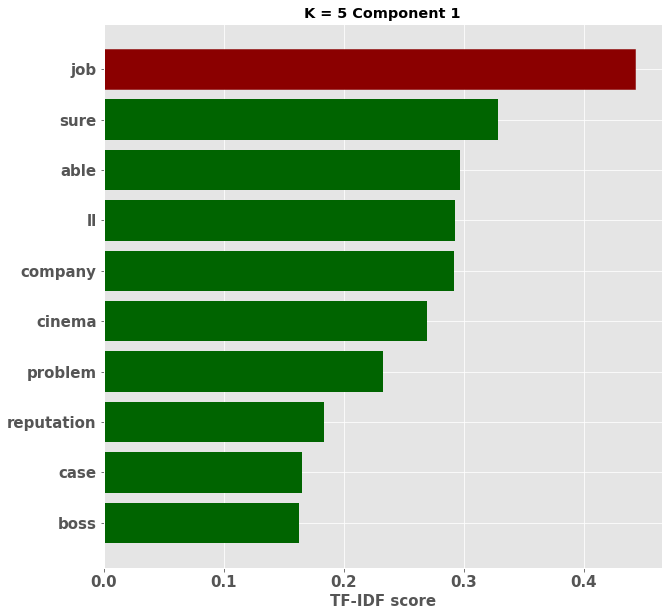

In [98]:

plt.figure(figsize=(10,10))

barplot = plt.barh(df1.term[:10][::-1], df1.score[:10][::-1], color='darkgreen')
barplot[-1].set_color('darkred')
plt.yticks(fontsize=15, weight='bold')
plt.xticks(fontsize=15, weight='bold')
plt.xlabel('TF-IDF score', fontsize=15, weight='bold')
plt.title('K = 5 Component 1', weight='bold')
plt.show()

# ordinary life (food, time, weather, entertainment etc.)

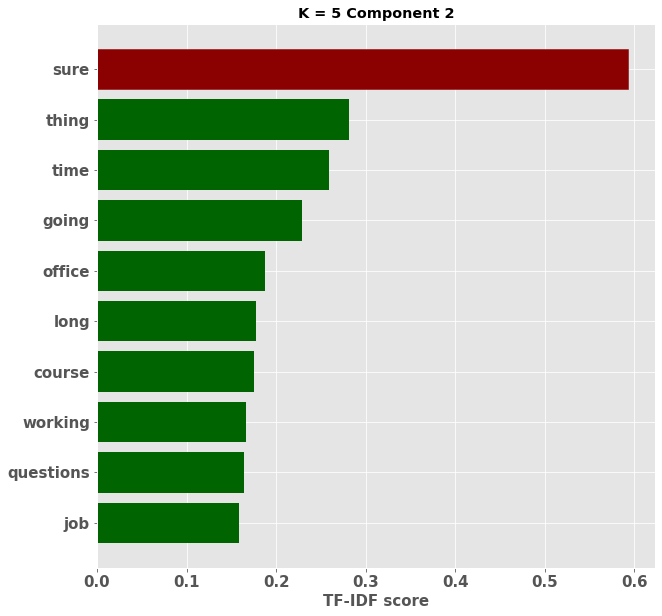

In [99]:

plt.style.use('ggplot')
plt.figure(figsize=(10,10))

barplot = plt.barh(df2.term[:10][::-1], df2.score[:10][::-1], color='darkgreen')
barplot[-1].set_color('darkred')
plt.yticks(fontsize=15, weight='bold')
plt.xticks(fontsize=15, weight='bold')
plt.xlabel('TF-IDF score', fontsize=15, weight='bold')
plt.title('K = 5 Component 2', weight='bold')
plt.show()

# education, financial 

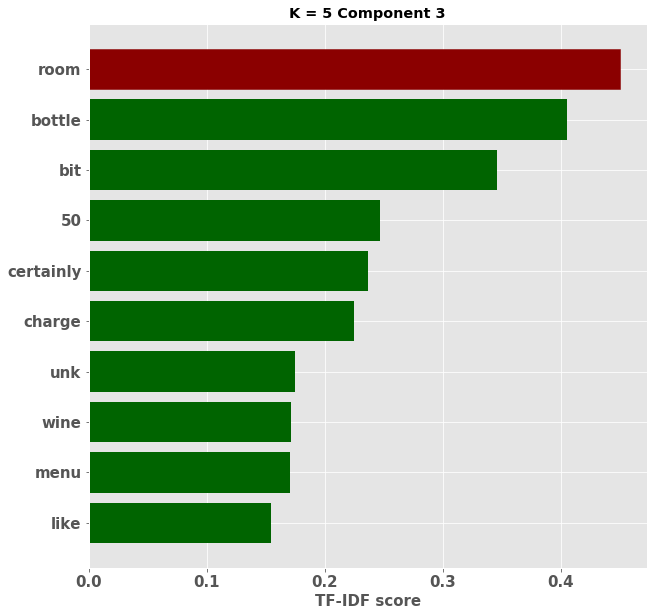

In [94]:

plt.style.use('ggplot')
plt.figure(figsize=(10,10))

barplot = plt.barh(df3.term[:10][::-1], df3.score[:10][::-1], color='darkgreen')
barplot[-1].set_color('darkred')
plt.yticks(fontsize=15, weight='bold')
plt.xticks(fontsize=15, weight='bold')
plt.xlabel('TF-IDF score', fontsize=15, weight='bold')
plt.title('K = 5 Component 3', weight='bold')
plt.show()
# 

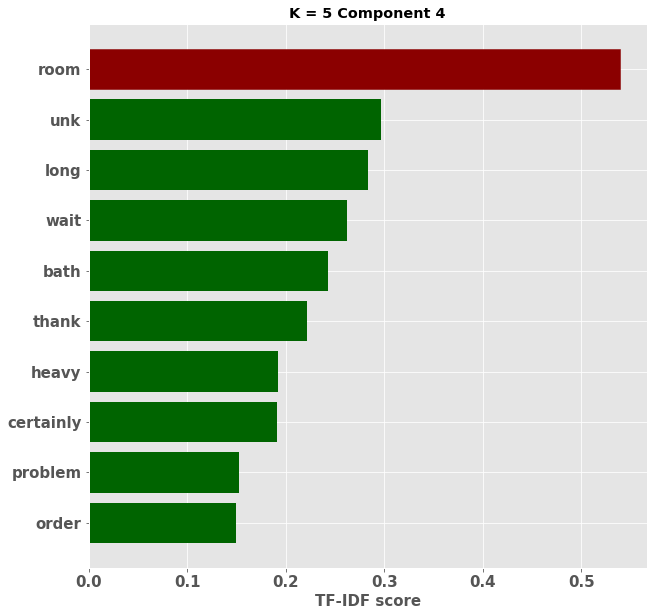

In [95]:

plt.style.use('ggplot')
plt.figure(figsize=(10,10))

barplot = plt.barh(df4.term[:10][::-1], df4.score[:10][::-1], color='darkgreen')
barplot[-1].set_color('darkred')
plt.yticks(fontsize=15, weight='bold')
plt.xticks(fontsize=15, weight='bold')
plt.xlabel('TF-IDF score', fontsize=15, weight='bold')
plt.title('K = 5 Component 4', weight='bold')
plt.show()
# 

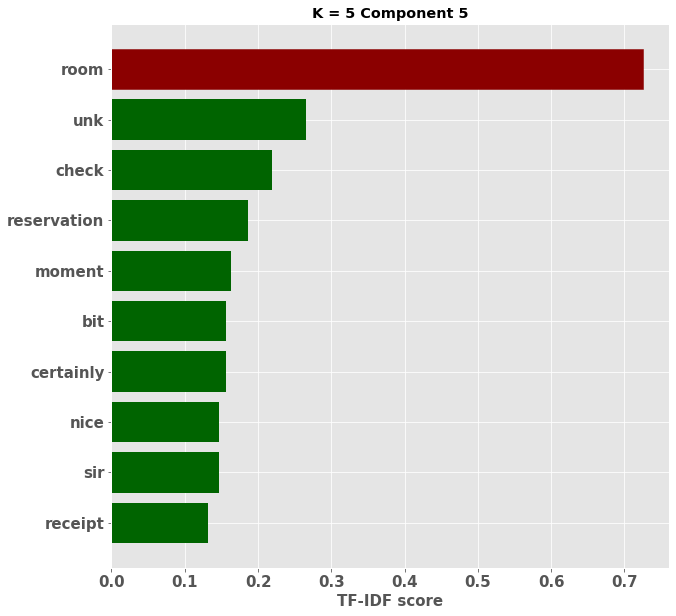

In [96]:

plt.style.use('ggplot')
plt.figure(figsize=(10,10))

barplot = plt.barh(df5.term[:10][::-1], df5.score[:10][::-1], color='darkgreen')
barplot[-1].set_color('darkred')
plt.yticks(fontsize=15, weight='bold')
plt.xticks(fontsize=15, weight='bold')
plt.xlabel('TF-IDF score', fontsize=15, weight='bold')
plt.title('K = 5 Component 5', weight='bold')
plt.show()
# 

## Select one context, visualize z

In [100]:
z_vec = []
all_labels = []
total_compo = 5
for i in range(total_compo):
    with open('Test_k5_Compo{}_z.pkl'.format(str(i)), 'rb') as handle:
        this_z = pickle.load(handle)
    z_vec.extend(this_z[0].detach().cpu().numpy())
    all_labels.extend(np.zeros(len(this_z[0]))+i)

In [101]:
z_vec = np.asarray(z_vec)
all_labels = np.asarray(all_labels)

In [102]:
z_vec.shape

(250, 200)

In [103]:
tsne = TSNE(n_components=2, random_state=0) # project to 2d
tsne_obj= tsne.fit_transform(z_vec) # very slow

In [104]:
tsne_df = pd.DataFrame({'X':tsne_obj[:,0],
                        'Y':tsne_obj[:,1],
                        'Component':all_labels})

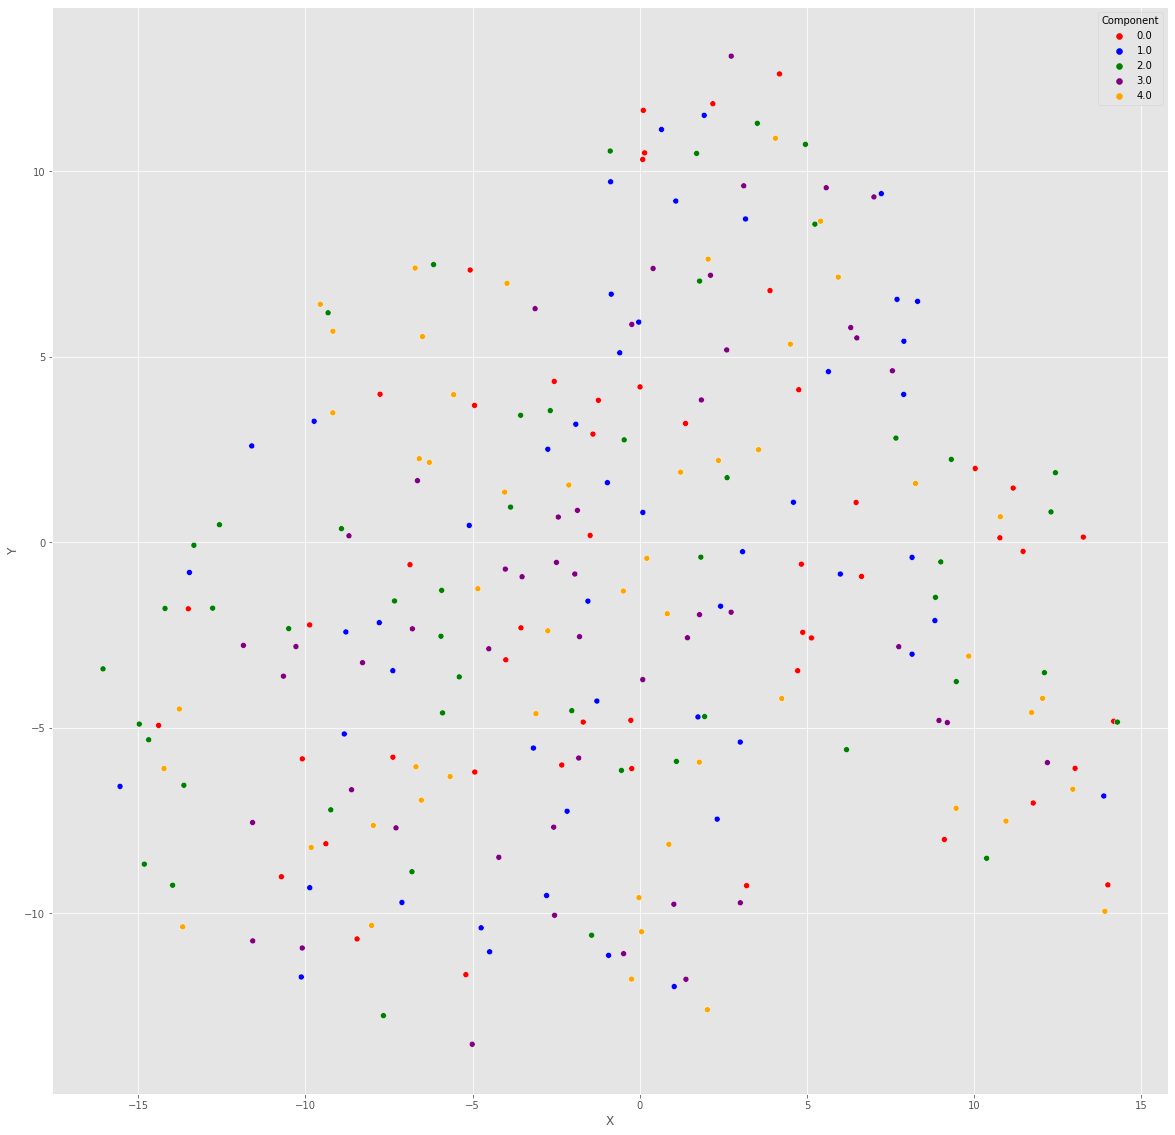

In [105]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x="X", y="Y", hue="Component", 
                palette=['red','blue','green', 'purple', 'orange'],
                legend='full',data=tsne_df)
plt.show()